In [1]:
import sys, os
from google.colab import drive, files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install catboost

     |████████████████████████████████| 64.8MB 78kB/s 


In [3]:
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option("display.max_columns", 100)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [ ]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

In [ ]:
df.label.value_counts()

correct      15495
incorrect     1681
Name: label, dtype: int64

In [ ]:
label_df = pd.DataFrame(df['label'])
feature_df = df.drop(columns='label')
feature_df.head()

In [ ]:
label_df['label_copy'] = label_df['label']
labels ={"label": {"correct": 1, "incorrect": 0}}
label_df.replace(labels, inplace=True)
label_df.head()

In [20]:
label_df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [ ]:
label_df.drop(columns='label_copy', inplace=True)
label_df.head()

# Feature Engineering

In [5]:
def set_trip_time(df):
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()

    return df.drop(columns=['pickup_time', 'drop_time'])

In [6]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)


def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances

    return feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'])

In [7]:
def set_time_error(feature_df):
    # time error is the error between given duration and the calculated trip time
    # from pickup and drop times
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2

In [8]:
def add_missing_col(df):
    '''
        This function adds an additional binary column to the df based on all
        additional_fare, duration, meter_waiting, meter_waiting_fare, meter_waiting_till_pickup, time_error
        has NaN values
    '''
    df['ismissing'] = np.where(df[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error']].isnull().all(1), 1, 0)


In [9]:
def set_cross_features(feature_df):

    # fare per minute = (fare / trip time) * 60
    feature_df['fare_per_min'] = np.where((feature_df['trip_time']==0), -1, (feature_df['fare'] / feature_df['trip_time'])*60)

    # fare per kilometer = fare / trip distance
    feature_df['fare_per_km'] = np.where((feature_df['trip_distance']==0), -1, (feature_df['fare'] / feature_df['trip_distance']))

    # vehicle mobile time per ruppee = (trip duration - meter waiting time) / fare
    feature_df['time_per_rs'] = np.where((feature_df['fare']==0), -1, ((feature_df['duration'] - feature_df['meter_waiting']) / feature_df['fare']))

    # meter waiting till pickup per ruppee = meter waiting till pickup / fare
    feature_df['pickup_wait_per_rs'] = np.where((feature_df['fare']==0), -1, (feature_df['meter_waiting_till_pickup'] / feature_df['fare']))

    # aditional fare factor = additional fare / (fare + additional fare)
    feature_df['additional_fare_factor'] = np.where((feature_df['fare']==0), -1, (feature_df['additional_fare'] / (feature_df['fare']+feature_df['additional_fare'])))

    # speed = trip distance / (duration - meter waiting time)
    feature_df['speed'] = np.where(((feature_df['duration']-feature_df['meter_waiting'])==0), -1, (feature_df['trip_distance'] / (feature_df['duration']-feature_df['meter_waiting'])) * 3600)

    '''
        FEATURES BELOW WERE NOT USED FOR THE BEST MODEL

    # kilometers per ruppee = trip distance / fare
    feature_df['km_per_rs'] = np.where((feature_df['fare']==0), -1, (feature_df['trip_distance'] / feature_df['fare']))

    # fare per, per minute distance =  (fare * trip time) / trip distance
    feature_df['faretime_per_km'] = np.where((feature_df['trip_distance']==0), -1, ((feature_df['fare']*feature_df['trip_time']) / (feature_df['trip_distance']*60)))
    
    # trip time per additional ruppee = trip time / additional fare
    feature_df['time_per_additional_rs'] = np.where((feature_df['additional_fare']==0), -1, (feature_df['trip_time'] / feature_df['additional_fare']))
    
    # waiting fare factor = meter waiting fare / (fare + meter waiting fare)
    feature_df['waiting_fare_factor'] = np.where((feature_df['fare']==0), -1, (feature_df['meter_waiting_fare'] / (feature_df['fare']+feature_df['meter_waiting_fare'])))
    
    # meter waiting fare per meter waiting minute = meter waiting fare / meter waiting
    feature_df['waiting_rs_per_min'] = np.where((feature_df['meter_waiting']==0), -1, (feature_df['meter_waiting_fare'] / feature_df['meter_waiting'])*60)
    
    # vehicle mobile time per mobile fare = (trip time - meter waiting time) / (fare - meter waiting fare)
    feature_df['time_per_mobrs'] = np.where(((feature_df['fare']-feature_df['meter_waiting_fare'])==0), -1, 
                                            ((feature_df['trip_time'] - feature_df['meter_waiting']) / (feature_df['fare']-feature_df['meter_waiting_fare'])))
    
    # inverse of above feature
    feature_df['mobfare_per_min'] = np.where(((feature_df['trip_time'] - feature_df['meter_waiting'])==0), -1, 
                                            ((feature_df['fare']-feature_df['meter_waiting_fare']) / (feature_df['trip_time'] - feature_df['meter_waiting']))*60)

    
    '''

In [10]:
def feature_process(feature_df):
    feature_df = set_trip_time(feature_df)
    feature_df = set_distance(feature_df)
    feature_df['fare'].fillna(10000, inplace=True)

    return feature_df

# Outlier Handling

## Z-Score

In [11]:
def remove_outliers(xdf, ydf):
    columns = xdf.columns
    index = xdf.index.values
    imputer = SimpleImputer(strategy='median')
    data = imputer.fit_transform(xdf)
    xdf = pd.DataFrame(data=data, columns=columns, index=index)
    xdf.index.name = 'tripid'
    z = np.abs(stats.zscore(xdf))
    outliers = np.where(z > 10)[0]
    xdf = xdf.drop(xdf.index[outliers])
    ydf = ydf.drop(ydf.index[outliers])

    return (xdf, ydf, imputer)

# Pre-Processing Methods

In [28]:
def preprocess_train(xdf, ydf):
    '''
        xdf - feature dataframe
    '''
    xdf = feature_process(xdf)
    xdf, ydf, imputer = remove_outliers(xdf, ydf)
    set_cross_features(xdf)
    columns = xdf.columns
    scaler = MinMaxScaler()
    x_out = scaler.fit_transform(xdf)
    xdf = pd.DataFrame(x_out, columns=columns, index=xdf.index.values)

    out = {'xdf': xdf, 'ydf': ydf, 'imputer': imputer, 'scaler': scaler}
    return out


In [31]:
def preprocess_test(xdf, imputer, scaler):
    '''
        preprocess_xtrain() must be called on training data before using this

        xdf - feature dataframe
        imputer - nimputer returned by preprocess_xtrain()
        scaler - nscaler returned by preprocess_xtrain()
    '''
    xdf = feature_process(xdf)
    columns = xdf.columns
    x_out = imputer.transform(xdf)
    xdf = pd.DataFrame(x_out, columns=columns, index=xdf.index.values)
    set_cross_features(xdf)
    columns = xdf.columns
    x_out = scaler.transform(xdf)
    df = pd.DataFrame(x_out, columns=columns, index=xdf.index.values)

    return df

# Model Evaluation

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import  CatBoostClassifier

model = CatBoostClassifier(thread_count=-1)

scale_pos_weight = [None, 0.1084866]
iterations = [900, 1000, 1100]
depth = [4, 6, 8, 10]
learning_rate = [0.02917799912393093, 0.01, 0.04]
l2_leaf_reg = [2.7, 3, 3.5]
subsample = [0.800000011920929, 0.7, 0.9]
eval_metric = ['Logloss', 'AUC']
bootstrap_type = ['MVS', 'Bernoulli', 'Bayesian']
bagging_temperature = [0.7, 1, 2, 4]


params1 = dict(scale_pos_weight = scale_pos_weight,
              iterations = iterations,
              depth = depth,
              learning_rate = learning_rate,
              bootstrap_type = bootstrap_type)

params2 = dict(l2_leaf_reg = l2_leaf_reg,
               eval_metric = eval_metric,
               bagging_temperature = bagging_temperature)

X = feature_df
y = label_df

pre_out = preprocess_train(X, y)
X = pre_out['xdf']
y = pre_out['ydf']

grid = GridSearchCV(estimator=model,
                    param_grid=params1,
                    scoring='roc_auc',
                    verbose=10,
                    n_jobs=-1)
grid.fit(X, y)

print("Best param: ",grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 10

0:	learn: 0.6843721	total: 70.7ms	remaining: 1m 3s
1:	learn: 0.6752809	total: 84.3ms	remaining: 37.9s
2:	learn: 0.6670551	total: 97.7ms	remaining: 29.2s
3:	learn: 0.6589791	total: 111ms	remaining: 24.9s
4:	learn: 0.6505679	total: 124ms	remaining: 22.2s
5:	learn: 0.6430166	total: 138ms	remaining: 20.5s
6:	learn: 0.6351489	total: 151ms	remaining: 19.3s
7:	learn: 0.6275869	total: 165ms	remaining: 18.4s
8:	learn: 0.6201692	total: 178ms	remaining: 17.6s
9:	learn: 0.6134717	total: 191ms	remaining: 17s
10:	learn: 0.6068429	total: 204ms	remaining: 16.5s
11:	learn: 0.6007815	total: 217ms	remaining: 16.1s
12:	learn: 0.5946700	total: 231ms	remaining: 15.7s
13:	learn: 0.5885668	total: 244ms	remaining: 15.5s
14:	learn: 0.5833407	total: 257ms	remaining: 15.2s
15:	learn: 0.5769192	total: 272ms	remaining: 15s
16:	learn: 0.5714490	total: 287ms	remaining: 14.9s
17:	learn: 0.5657740	total: 299ms	remaining: 14.7s
18:	learn: 0.5597634	total: 312ms	remaining: 14.5s
19:	learn: 0.5540069	total: 325ms	remainin

In [ ]:
print(grid.best_score_)
grid.best_estimator_.get_all_params()

0.9424457106966461


{'auto_class_weights': 'None',
 'bayesian_matrix_reg': 0.10000000149011612,
 'best_model_min_trees': 1,
 'boost_from_average': False,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'border_count': 254,
 'class_names': [0, 1],
 'class_weights': [1, 0.1084866002202034],
 'classes_count': 0,
 'depth': 6,
 'eval_metric': 'Logloss',
 'feature_border_type': 'GreedyLogSum',
 'grow_policy': 'SymmetricTree',
 'iterations': 900,
 'l2_leaf_reg': 3,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'leaf_estimation_iterations': 10,
 'leaf_estimation_method': 'Newton',
 'learning_rate': 0.009999999776482582,
 'loss_function': 'Logloss',
 'max_leaves': 64,
 'min_data_in_leaf': 1,
 'model_shrink_mode': 'Constant',
 'model_shrink_rate': 0,
 'model_size_reg': 0.5,
 'nan_mode': 'Min',
 'penalties_coefficient': 1,
 'random_seed': 0,
 'random_strength': 1,
 'rsm': 1,
 'sampling_frequency': 'PerTree',
 'score_function': 'Cosine',
 'sparse_features_conflict_fraction': 0,
 'subsample': 0.80000001192

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from catboost import  CatBoostClassifier

X = feature_df
y = label_df

pre_out = preprocess_train(X, y)
X = pre_out['xdf']
y = pre_out['ydf']

model = CatBoostClassifier(bootstrap_type='Bayesian', depth=8, iterations=1100, learning_rate=0.03999999910593033, 
                        boosting_type='Ordered',bagging_temperature=0.7, 
                        eval_metric='Logloss', l2_leaf_reg=2.7, thread_count=-1)
fit_params = {'verbose': 200}

CV = 5
cv_df = pd.DataFrame(index=range(CV))
entries = []
f1_scores = cross_val_score(model, X, y.label, scoring='f1_macro', cv=5, fit_params=fit_params)
for fold_idx, f1 in enumerate(f1_scores):
    entries.append((fold_idx, f1))
cv_df = pd.DataFrame(entries, columns=['fold_idx', 'f1_macro'])

print(cv_df)
print("Mean F1_macro score: ", cv_df.f1_macro.mean())

0:	learn: 0.6309482	total: 105ms	remaining: 1m 55s
200:	learn: 0.1112260	total: 19.4s	remaining: 1m 26s
400:	learn: 0.1033094	total: 33.8s	remaining: 58.9s
600:	learn: 0.0980206	total: 49.2s	remaining: 40.8s
800:	learn: 0.0945951	total: 1m 3s	remaining: 23.6s
1000:	learn: 0.0925626	total: 1m 16s	remaining: 7.55s
1099:	learn: 0.0914699	total: 1m 23s	remaining: 0us
0:	learn: 0.6290633	total: 98.7ms	remaining: 1m 48s
200:	learn: 0.1049224	total: 19.1s	remaining: 1m 25s
400:	learn: 0.0987444	total: 32.7s	remaining: 57s
600:	learn: 0.0933272	total: 48.4s	remaining: 40.2s
800:	learn: 0.0899699	total: 1m 3s	remaining: 23.9s
1000:	learn: 0.0877941	total: 1m 18s	remaining: 7.76s
1099:	learn: 0.0871202	total: 1m 25s	remaining: 0us
0:	learn: 0.6298920	total: 108ms	remaining: 1m 58s
200:	learn: 0.1076964	total: 19.3s	remaining: 1m 26s
400:	learn: 0.0978618	total: 36.8s	remaining: 1m 4s
600:	learn: 0.0920262	total: 53.8s	remaining: 44.7s
800:	learn: 0.0873029	total: 1m 11s	remaining: 26.5s
1000:	le

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

pre_out = preprocess_train(X_train, y_train)
X_train = pre_out['xdf']
y_train = pre_out['ydf']

X_eval = preprocess_test(X_eval , imputer=pre_out['imputer'], scaler=pre_out['scaler'])

eval_set = (X_eval, y_eval)

In [33]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(bootstrap_type='Bayesian', depth=8, iterations=1100, learning_rate=0.03999999910593033, 
                        boosting_type='Ordered',bagging_temperature=0.7, 
                        eval_metric='Logloss', l2_leaf_reg=2.7, thread_count=-1)

clf.fit(X_train, y_train, verbose=100) 
preds = clf.predict(X_eval)

0:	learn: 0.6309878	total: 140ms	remaining: 2m 33s
100:	learn: 0.1181094	total: 8.41s	remaining: 1m 23s
200:	learn: 0.1076081	total: 15.8s	remaining: 1m 10s
300:	learn: 0.1027612	total: 22.6s	remaining: 1m
400:	learn: 0.0985696	total: 29.8s	remaining: 52s
500:	learn: 0.0962502	total: 36.7s	remaining: 43.9s
600:	learn: 0.0940262	total: 43.8s	remaining: 36.3s
700:	learn: 0.0913818	total: 50.7s	remaining: 28.9s
800:	learn: 0.0893591	total: 58s	remaining: 21.6s
900:	learn: 0.0879163	total: 1m 5s	remaining: 14.4s
1000:	learn: 0.0865836	total: 1m 12s	remaining: 7.13s
1099:	learn: 0.0851029	total: 1m 19s	remaining: 0us


In [34]:
print(clf.get_feature_importance(prettified=True))

                   Feature Id  Importances
0                 time_per_rs    21.162874
1                        fare    11.874479
2                 fare_per_km     9.720141
3   meter_waiting_till_pickup     8.027924
4                fare_per_min     7.669549
5                       speed     6.546844
6          pickup_wait_per_rs     6.006701
7               trip_distance     6.001065
8      additional_fare_factor     5.404910
9                    duration     4.567757
10            additional_fare     4.214300
11              meter_waiting     4.049130
12                  trip_time     2.603560
13         meter_waiting_fare     2.150765


## Evaluaton Results

In [ ]:
# Submission 43 - sub 42 with diff params
# bootstrap_type='Bayesian', depth=8, iterations=1100, learning_rate=0.03999999910593033, 
                        # boosting_type='Ordered',bagging_temperature=0.7, 
                        # eval_metric='Logloss', l2_leaf_reg=2.7, thread_count=-1

print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))
print("Mean CV F1_macro: ", cv_df.f1_macro.mean())

# same best score - 0.97962

F1_Score: 0.9770358934774218
Macro F1_Score: 0.8663413553629409
Mean CV F1_macro:  0.8639371533852651


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 15.0, 'Predicted')

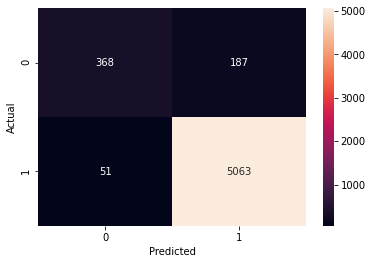

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_eval, preds)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Predicting on Test Data

In [37]:
%%time 
from catboost import CatBoostClassifier

pre_out = preprocess_train(feature_df, label_df)
feature_df = pre_out['xdf']
label_df = pre_out['ydf']

clf = CatBoostClassifier(bootstrap_type='Bayesian', depth=8, iterations=1100, learning_rate=0.03999999910593033, 
                        boosting_type='Ordered',bagging_temperature=0.7, 
                        eval_metric='Logloss', l2_leaf_reg=2.7, thread_count=-1)

clf.fit(feature_df, label_df, verbose=100)

0:	learn: 0.6357558	total: 118ms	remaining: 2m 9s
100:	learn: 0.1184147	total: 11.3s	remaining: 1m 52s
200:	learn: 0.1087430	total: 22s	remaining: 1m 38s
300:	learn: 0.1045449	total: 31.6s	remaining: 1m 23s
400:	learn: 0.1006705	total: 42s	remaining: 1m 13s
500:	learn: 0.0976859	total: 52.1s	remaining: 1m 2s
600:	learn: 0.0955199	total: 1m 2s	remaining: 51.7s
700:	learn: 0.0939795	total: 1m 11s	remaining: 40.6s
800:	learn: 0.0927806	total: 1m 20s	remaining: 30.2s
900:	learn: 0.0915245	total: 1m 30s	remaining: 19.9s
1000:	learn: 0.0904911	total: 1m 39s	remaining: 9.81s
1099:	learn: 0.0895054	total: 1m 48s	remaining: 0us
CPU times: user 3min 20s, sys: 15.1 s, total: 3min 35s
Wall time: 1min 52s


In [38]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

test_features_df = preprocess_test(test_features_df, imputer=pre_out['imputer'], scaler=pre_out['scaler'])
print(test_features_df.shape)

(8576, 14)


In [39]:
test_predictions = clf.predict(test_features_df)

In [40]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_predictions

submission_df.head()

In [42]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/TaxiFare/my_best_submission.csv', index=True)

In [ ]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/TaxiFare/my_submission.csv